In [1]:
import scanpy
import scipy.sparse as sp
import os
import numpy as np
from scipy.spatial import Delaunay
import pandas as pd 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image  
Image.MAX_IMAGE_PIXELS = None

In [2]:
scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
# rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

In [3]:
asavepath=os.path.join('/mnt/xinyi/','starmap','a')
proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')

In [10]:
def getA_delaunay(samplename,savepath=None):
    a_size=scaleddata.shape[0]
    a=sp.lil_matrix((a_size,a_size))
    
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()
    tri = Delaunay(sobj_coord_np)
    
    a_size=sobj_coord_np.shape[0]
    a=sp.lil_matrix((a_size,a_size))
    for tri_i in range(tri.simplices.shape[0]):
        tri_i_idx=tri.simplices[tri_i,:]
        a[tri_i_idx[0],tri_i_idx[1]]=1
        a[tri_i_idx[1],tri_i_idx[0]]=1
        a[tri_i_idx[0],tri_i_idx[2]]=1
        a[tri_i_idx[2],tri_i_idx[0]]=1
        a[tri_i_idx[1],tri_i_idx[2]]=1
        a[tri_i_idx[2],tri_i_idx[1]]=1
    
    a=a.tocsr()
    if savepath !=None:
        sp.save_npz(savepath,a)
    return a

def getA_knn(samplename,k,a_mode,savepath=None):
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(sobj_coord_np)
    a=nbrs.kneighbors_graph(sobj_coord_np,mode=a_mode)
    if a_mode=='connectivity':
        a=a-sp.identity(sobj_coord_np.shape[0],format='csr')
    if a_mode=='distance':
        a[a!=0]=1/a[a!=0]
    if savepath !=None:
        sp.save_npz(savepath,a)
    return a

In [27]:
def getA_physicalDist(samplename,distThresh,a_mode,savepath=None):
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()
    allDist=euclidean_distances(sobj_coord_np,sobj_coord_np)
    minDist=np.min(allDist[allDist != 0])
    thresh=distThresh*minDist
    a=np.zeros_like(allDist)
    edgeIdx=np.logical_and(allDist<thresh,allDist!=0)
    if a_mode=='connectivity':
        a[edgeIdx]=1
    elif a_mode=='distance':
        a[edgeIdx]=1/allDist[edgeIdx]
    else:
        print('a mode not supported')
    a=sp.csr_matrix(a)
    if savepath !=None:
        sp.save_npz(savepath,a)
    return a

In [ ]:
def getPixByDist(img,Ithresh,distList,savepath):
    

In [11]:
for samplename in ['AD_mouse9494','AD_mouse9498','AD_mouse9723','AD_mouse9735']:
#     getA_delaunay(samplename,os.path.join(asavepath,'a_delaunay_'+samplename+'.npz'))
#     getA_knn(samplename,5,'connectivity',os.path.join(asavepath,'knn5_connectivity_'+samplename+'.npz'))
    getA_knn(samplename,5,'distance',os.path.join(asavepath,'knn5_distance_'+samplename+'.npz'))
#     getA_knn(samplename,10,'connectivity',os.path.join(asavepath,'knn10_connectivity_'+samplename+'.npz'))
    getA_knn(samplename,10,'distance',os.path.join(asavepath,'knn10_distance_'+samplename+'.npz'))
#     getA_knn(samplename,20,'connectivity',os.path.join(asavepath,'knn20_connectivity_'+samplename+'.npz'))
    getA_knn(samplename,20,'distance',os.path.join(asavepath,'knn20_distance_'+samplename+'.npz'))


In [28]:
for samplename in ['AD_mouse9494','AD_mouse9498','AD_mouse9723','AD_mouse9735']:
    for d in [2,3,4,5]:
        getA_physicalDist(samplename,d,'connectivity',os.path.join(asavepath,'physicalDist_'+str(d)+'_connectivity_'+samplename+'.npz'))
        getA_physicalDist(samplename,d,'distance',os.path.join(asavepath,'physicalDist_'+str(d)+'_distance_'+samplename+'.npz'))

In [29]:
testa=sp.load_npz(os.path.join(asavepath,'physicalDist_3_connectivity_AD_mouse9494.npz'))

(array([2.954e+03, 2.746e+03, 1.698e+03, 9.090e+02, 0.000e+00, 7.110e+02,
        6.080e+02, 3.180e+02, 7.500e+01, 2.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

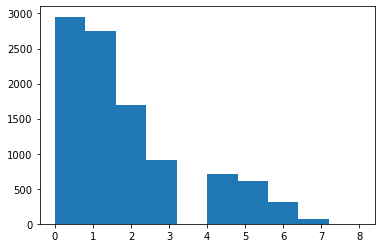

In [38]:
plt.hist(np.sum(testa.toarray(),1))


(array([1779., 2935., 2017., 1025.,  584.,  445.,  461.,  505.,  237.,
          33.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

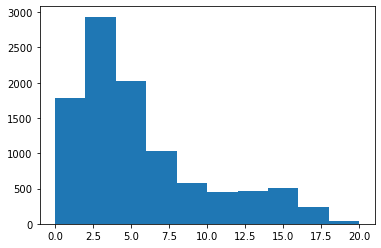

In [40]:
testa=sp.load_npz(os.path.join(asavepath,'physicalDist_5_connectivity_AD_mouse9494.npz'))
plt.hist(np.sum(testa.toarray(),1))

In [41]:
np.sum(np.sum(testa.toarray(),1)==0)

607

In [5]:
for samplename in ['AD_mouse9494','AD_mouse9498','AD_mouse9723','AD_mouse9735']:
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()
    allDist=euclidean_distances(sobj_coord_np,sobj_coord_np)
    minDist=np.min(allDist[allDist != 0])
    print(samplename,minDist)

AD_mouse9494 13.0
AD_mouse9498 14.422205101855956
AD_mouse9723 12.727922061357855
AD_mouse9735 11.180339887498949


In [6]:
for samplename in ['AD_mouse9494','AD_mouse9498','AD_mouse9723','AD_mouse9735']:
    PlaqueintensityThresh=30
    TauintensityThresh=30
    PlaqueDistList_scaled=[32,64,96,128,160,192]
    TauDistList_scaled=[3,6,12,24,48,96]
    datapath='/mnt/xinyi/2021-01-13-mAD-test-dataset/'
    cellCoord=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()
    plaquePath_scaled=os.path.join(datapath,samplename,'segmentation/scaled','plaque.tif')
    tauPath_scaled=os.path.join(datapath,samplename,'segmentation/scaled','tau.tif')
    ps=mpimg.imread(plaquePath_scaled).copy()
    ts=mpimg.imread(tauPath_scaled).copy()
    ps[ps<PlaqueintensityThresh]=0
    ts[ts<TauintensityThresh]=0
    ps[ps>=PlaqueintensityThresh]=1
    ts[ts>=TauintensityThresh]=1
    plaquePixBinary=np.zeros((cellCoord.shape[0],len(PlaqueDistList_scaled)))
    tauPixBinary=np.zeros((cellCoord.shape[0],len(TauDistList_scaled)))
    for c in range(cellCoord.shape[0]):
        prePlaque=0
        preParea=0
        for p in range(len(PlaqueDistList_scaled)):
            pdist=PlaqueDistList_scaled[p]
            currPlaque=np.sum(ps[max(0,cellCoord[c,1]-pdist):min(ps.shape[0],cellCoord[c,1]+pdist),max(0,cellCoord[c,0]-pdist):min(ps.shape[1],cellCoord[c,0]+pdist)])
            currPArea=(min(ps.shape[0],cellCoord[c,1]+pdist)-max(0,cellCoord[c,1]-pdist))*(min(ps.shape[1],cellCoord[c,0]+pdist)-max(0,cellCoord[c,0]-pdist))
            plaquePixBinary[c,p]=(currPlaque-prePlaque)/(currPArea-preParea)*np.square(PlaqueDistList_scaled[0])
            prePlaque=currPlaque
            preParea=currPArea
    for c in range(cellCoord.shape[0]):
        preTau=0
        preTarea=0
        for p in range(len(TauDistList_scaled)):
            pdist=TauDistList_scaled[p]
            currTau=np.sum(ts[max(0,cellCoord[c,1]-pdist):min(ts.shape[0],cellCoord[c,1]+pdist),max(0,cellCoord[c,0]-pdist):min(ts.shape[1],cellCoord[c,0]+pdist)])
            currTArea=(min(ts.shape[0],cellCoord[c,1]+pdist)-max(0,cellCoord[c,1]-pdist))*(min(ts.shape[1],cellCoord[c,0]+pdist)-max(0,cellCoord[c,0]-pdist))
            tauPixBinary[c,p]=(currTau-preTau)/(currTArea-preTarea)*np.square(TauDistList_scaled[0])
            preTau=currTau
            preTarea=currTArea
    res=np.hstack((plaquePixBinary,tauPixBinary))
    res=sp.csr_matrix(res)
    sp.save_npz(os.path.join(proteinsavepath,samplename+'_scaled_binary'),res)

In [5]:
plaquePixBinary

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [41]:
cellCoord[0]

array([905,   5])

In [42]:
cellCoord[1]

array([2366,    7])

In [30]:

sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==samplename,['x','y']].to_numpy()

In [31]:
print(np.min(sobj_coord_np[:,0]))
print(np.max(sobj_coord_np[:,0]))
print(np.min(sobj_coord_np[:,1]))
print(np.max(sobj_coord_np[:,1]))

5
6697
5
6651


In [33]:
plaquePath_scaled=os.path.join(datapath,samplename,'segmentation/scaled','plaque.tif')
tauPath_scaled=os.path.join(datapath,samplename,'segmentation/scaled','tau.tif')
ps_scaled=mpimg.imread(plaquePath_scaled).copy()
ts_scaled=mpimg.imread(tauPath_scaled).copy()

In [34]:
ps_scaled.shape

(6663, 6703)

In [35]:
ts_scaled.shape

(6663, 6703)

In [38]:
6703/22344

0.29999104905119944